# Redes neuronales totalmente conexas 

En este cuaderno vamos a construir redes neurnales *clásicas", es decir tal y como se concebían antes de la llegada del *Deep Learning".

Este tipo de redes recibe diversos nombres: <br>
 · En inglés se denominan habitualmente **_MultiLayer Perceptron_ (MLP)** o **_Fully Connected_ (FC)**<br>
 · En castellano se traducen como **Perceptrón multicapa** (en mi opinión debería ser más bien _multicapa de perceptrones_), <br>
$\quad$**Totalmente conectadas/conexas**, y también **Densas** por influencia Tensorflow.

Este tipo de redes no está ni mucho menos obsoleta, y se pueden encontrar en soluciones de Deep Learning como parte final de la red, para realizar la tarea para la que ha sido diseñada.

---

    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2020, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2020, URJC (Spain)

    alfredo.cuesta@urjc.es    

#### Preliminares
Paquetes de propósito general (_numpy_, _matplotlib_)

In [1]:
#-[0]. General purpose packages

import numpy as np
import matplotlib.pyplot as plt

**Cargar el MNIST**

In [2]:
#-[1]. Load images. Keras has a few benchmark datasets readily available.

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#--- Get info of train and test data sets
N_train,dim0,dim1 = x_train.shape
N_test,dim0,dim1  = x_test.shape
num_classes = 10
num_pixels = dim0*dim1

### Construcción de la red
+ Una red densa tiene:
    + Una capa de entrada
    + Una o varias capas ocultas
    + Una capa de salida

Keras nos proporciona objetos para replicar esta estructura de capas
+ **La capa de entrada** está compuesta por neuronas de entrada; tantas como el número de características (la dimensión) de los ejemplos. Cada neurona tiene una sola entrada, sus pesos están fijos a 1, su bias a 0 y su función de activación es lineal.
+ **Cada capa oculta** consiste en un número de neuronas. Cada una de estas neuronas se conecta con todas las salidas de la capa anterior. Todas tienen (salvo que se diga lo contrario) un valor de bias diferente de 0, y la misma función de activación.
+ **La capa de salida** es similar a una capa oculta, pero el número de neuronas y su función de activación depende de la tarea que vayamos a realizar.
    + Si, por ej., vamos a hacer clasificación habrá una neurona por cada clase diferente y la función de activación será *Softmax*

In [3]:
#-[2]. Modeling the neural network in three different ways

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation

choice_code = 'all_in_one' # options are: 'all_in_one' , 'with_add' , 'stacking'
num_hidden_neurons = 32

if choice_code == 'all_in_one':
  model = Sequential([
      Dense(num_hidden_neurons, input_shape=(num_pixels,)),  #<-- input_shape requires ','
      Activation('relu'),
      Dense(num_classes),
      Activation('softmax'),
  ])

elif choice_code == 'with_add':
  model = Sequential()
  model.add(Dense(num_hidden_neurons, input_dim=num_pixels))  #<-- input_dim does not !! 
  model.add(Activation('relu'))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

elif choice_code == 'stacking':  
  x  = Input(shape=(num_pixels,))            #<-- shape requires ',' 
  h = Dense(num_hidden_neurons)(x)           #
  h = Activation('relu')(h)                  #   BUT shape is a parameter of the Input layer
  z = Dense(num_classes)(h)                  #   NOT of the Dense layer
  y = Activation('softmax')(z)
  model = Model(x,y)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### _Compilar_ el modelo

+ Para compilar el modelo tenemos que seleccionar un optimizador y una función de pérdida.
+ También se puede elegir un conjunto de métricas para evaluar el proceso de entrenamiento.

In [4]:
choice_problem = 'Nclasses' # options are: 'Nclasses', '2classes', 'regression'

# For a multi-class classification problem
if choice_problem == 'Nclasses':
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# For a binary classification problem
elif choice_problem == '2classes':
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# For a mean squared error regression problem
elif choice_problem == 'regression':
  model.compile(optimizer='rmsprop',
                loss='mse')

else:
  print('--- choose a valid option ---')

## Aprendizaje

**1. Preparamos el conjunto de datos para que pueda ser procesado por el modelo**  <br>
       _En este caso tenemos que serializar las imágenes, de matrices $28\times28$ a vectores de $784$_

In [5]:
x_flat = x_train.reshape( (N_train,num_pixels) )

**2. Preparamos el vector de etiquetas para tenga una representación 1-hot**  <br>
       _Si el problema no fuera multi-clase no sería necesario_

In [6]:
from tensorflow.keras.utils import to_categorical

y_1hot = to_categorical(y_train, num_classes=num_classes)

**3. Ejecutar el método FIT**<br>estandar
_Tensorflow sigue el estandar de Scikit-Learn. Pero a diferencia de otros métodos que hemos visto de ML, en DL hay que especificar algunas otra opciones como el número de épocas o el tamaño del lote.
+ El **número de épocas** indica cuantas veces se utiliza el conjunto de entrenamiento para realizar el aprendizaje
+ El **tamaño del lote** es el número de muestras que se utilizan para calcular el descenso del gradiente.

In [7]:
# Train the model, iterating on the data in batches of 32 samples
N_epochs = 1
batch_size = 32
model.fit(x_flat, y_1hot, epochs=N_epochs, batch_size=batch_size)

1875/1875 [==============================] - 2s 935us/step - loss: 1.8623 - accuracy: 0.7074


## Test

**1. Debemos procesar los datos de test igual que procesamos los de entrenamiento**

In [8]:
x = x_test.reshape( (N_test,dim0*dim1) )

**2. También pasamos el 'ground truth'** (las etiquetas del conjunto de test) **a una representación 1-hot**<br>


In [9]:
y = to_categorical( y_test, num_classes=num_classes )

**3. ejecutar el método PREDICT**

In [10]:
yhat = model.predict(x)
#-> 'yhat' is the outcome of the NN = an array with 'num_classes' elements, with the probability of each class
#      in other words, it is a PMF across all the possible classes

class_hat = np.argmax(yhat, axis=-1)
#-> 'class_hat' is the class with the highest probability

class_prob = np.max(yhat, axis=-1)
#-> 'class_prob' is the probability of 'class_hat'

# NOTE: axis = -1 refers the last axis of the numpy array 

+ El método `evaluate` calcula el promedio de la pérdida y la(s) metrica(s) elegidas al compilar el modelo con tantos lotes como permita el tamaño del conjunto de datos y el tamaño del lote.

In [11]:
score = model.evaluate(x, y, batch_size=128)
strlog = "\nEVALUATION: Loss = %0.2f %% , Accuracy = %0.2f %%" %(score[0]*100, score[1]*100)
print(strlog)

79/79 [==============================] - 0s 1ms/step - loss: 0.8509 - accuracy: 0.8366

EVALUATION: Loss = 85.09 % , Accuracy = 83.66 %


+ También podemos probar a elegir una imágen y pasársela al modelo para que la clasifique.

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] <-- y: number  8 

[0.0622643  0.04229899 0.09021036 0.13264231 0.05641079 0.17652126
 0.05727628 0.0577919  0.25188848 0.07269534] <-- yhat: number 8


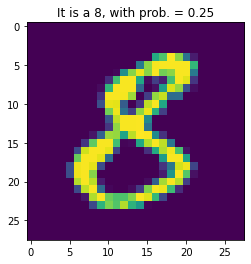

In [12]:
k = 1234
print( y[k,:],   '<-- y: number '    ,np.argmax(y[k,:]) ,'\n')
print( yhat[k,:],'<-- yhat:','number',class_hat[k] )
plt.imshow(x_test[k,:,:])
strtitle = 'It is a %d, with prob. = %0.2f' %(class_hat[k],class_prob[k])
plt.title(strtitle)
plt.show()

## Ejercicios

1. Crear la función `mi_modelo( x_shape, y_shape, layer_list )` que encapsule el modelo de tu red neuronal y reciba como parámetros las dimensiones del datos de entrada  y del vector de etiquetas.
2. Modificar el modelo para que admita las imágenes como matrices $28\times28$ en vez de como vectores de $784$ elementos. Para ello habrá que utilizar el método `Flatten` de Keras.

#### Solución

79/79 [==============================] - 0s 1ms/step - loss: 1.1421 - accuracy: 0.6195

EVALUATION: Loss = 114.21 % , Accuracy = 61.95 %
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] <-- y: number  8 

[0.03703575 0.03327731 0.20063815 0.04407239 0.06334855 0.12512945
 0.18681869 0.02824518 0.19328591 0.0881486 ] <-- yhat: number 2


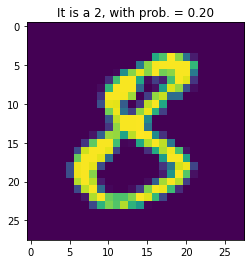

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                660       
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

def mi_modelo(x_shape, y_shape, layer_list, activation = 'relu'):
    x = Input(shape=x_shape)
    h = Flatten()(x)
    for num_h in layer_list:
        h = Dense(num_h)(h)   
        h = Activation(activation)(h)
    z = Dense(y_shape)(h)
    y = Activation('softmax')(z)
    return Model(x,y)
#================================================================
(x_train, y_train), (x_test, y_test) = mnist.load_data()
N_train,dim0,dim1 = x_train.shape
N_test,dim0,dim1  = x_test.shape
num_classes = 10
y_1hot = to_categorical(y_train, num_classes=num_classes)
y = to_categorical(y_test, num_classes=num_classes)
#-----------------------------
N_epochs = 1
batch_size = 32
list_hidden_neurons = [32,20,10]
#-----------------------------
model = mi_modelo((dim0,dim1), num_classes, list_hidden_neurons)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_1hot, epochs=N_epochs, batch_size=batch_size)
#-----------------------------
yhat = model.predict(x_test)
class_hat = np.argmax(yhat, axis=-1)
class_prob = np.max(yhat, axis=-1)
score = model.evaluate(x_test, y, batch_size=128)
strlog = "\nEVALUATION: Loss = %0.2f %% , Accuracy = %0.2f %%" %(score[0]*100, score[1]*100)
print(strlog)
#-----------------------------
k = 1234
print( y[k,:],   '<-- y: number '    ,np.argmax(y[k,:]) ,'\n')
print( yhat[k,:],'<-- yhat:','number',class_hat[k] )
plt.imshow(x_test[k,:,:])
strtitle = 'It is a %d, with prob. = %0.2f' %(class_hat[k],class_prob[k])
plt.title(strtitle)
plt.show()
model.summary()